<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

# Imports and settings

In [1]:
!pip install -U torchinfo gdown gshell

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 5.7 MB 4.6 MB/s 
  Created wheel for gdown: filename=gdown-4.2.0-py3-none-any.whl size=14273 sha256=a71e315b0e1367b46754af705cd171d8f12cd860a0e83d455eee4b1894e674de
  Stored in directory: /root/.cache/pip/wheels/8c/17/ff/58721d1fabdb87c21a0529948cf39e2be9af90ddbe4ad65944
  Created wheel for gshell: filename=gshell-5.5.4-py3-none-any.whl size=5773519 sha256=61f7a7e94f0974f583f9d38a93593c0ddf40a5c8d0a4cbe4d400f3c31303b689
  Stored in directory: /root/.cache/pip/wheels/90/47/14/4a354d97721718a2011e08740570211cb02cf5020703ea3597
Successfully built gdown gshell
  Attempting uninstall: gdown
    Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


In [2]:
import getpass
import itertools
import joblib
import os
import pexpect
import pickle
import random
import shutil
import subprocess
import sys
import time
import zipfile

import IPython

import gdown
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm.notebook as tqdm
%matplotlib inline

import skimage
import skimage.io
import skimage.transform

import sklearn
import sklearn.model_selection
import sklearn.manifold
import sklearn.metrics
import sklearn.neighbors
import sklearn.cluster
import sklearn.preprocessing

import torch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as data_utils
import torchvision.transforms as tt
import torchvision.models as vision_models
import torchvision.utils as vision_utils
import torchvision.datasets as vision_datasets
import torchinfo

In [3]:
sns.set(style='darkgrid', font_scale=1.2)
plt.rcParams["figure.figsize"] = (20, 20)

# Setting random seeds for reproducibility

In [4]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)

# Determining available device

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


# Setting globals

In [6]:
TRAIN_TIMES = []
BATCH_SIZE = 512
LATENT_SPACE_SIZE = 100
IMAGE_SIZE = 64
NORMALIZATION_PARAMS = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
SAMPLE_DIR = "/content/sample_dir"

In [7]:
try:
    os.mkdir(SAMPLE_DIR)
except FileExistsError:
    pass # already exists

# Helper functions and classes

In [8]:
class FacesDataset(data_utils.Dataset):
    def __init__(self, img_dir, transform=None, in_memory=False):
        self.img_dir = os.path.abspath(img_dir)
        self.img_names = sorted(list(os.listdir(self.img_dir)))
        self.transform = transform
        self.in_memory = in_memory
        self.data = None
        if self.in_memory:
            self.data = []
            for i in tqdm.tqdm(self.img_names, desc="Reading images", unit="images", unit_scale=False):
                image = skimage.img_as_float32(skimage.io.imread(os.path.join(img_dir, i)))
                self.data.append(image)
    
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        if self.in_memory:
            image = self.data[idx]
        else:
            img_path = os.path.join(self.img_dir, self.img_names[idx])
            image = skimage.img_as_float32(skimage.io.imread(img_path))
        if self.transform:
            image = self.transform(image)
        return image

In [9]:
class GaussianNoise(nn.Module):
    def __init__(self, sigma=0.1):
        super().__init__()
        self.sigma = sigma
        self.noise = torch.tensor(0).to(DEVICE)

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach()
            sampled_noise = self.noise.repeat(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x

In [10]:
def noisy_targets(targets, p=0.05, mode="real"):
    targets = targets.squeeze()
    if not mode in ("real", "fake"):
        raise ValueError("Unrecognized noisy targets mode")
    n_select = int(p * int(targets.size(0)))
    idx = torch.LongTensor(np.random.choice([i for i in range(int(targets.size(0)))], size=n_select)).to(targets.device)
    if mode == "real":
        values = torch.empty((n_select,)).uniform_(0., 0.3).to(targets.device)
        targets.index_copy_(0, idx, values)
    else:
        values = torch.empty((n_select,)).uniform_(0.7, 1.2).to(targets.device)
        targets.index_copy_(0, idx, values)
    idx, values = idx.cpu(), values.cpu()
    del idx, values
    return targets.unsqueeze(-1)

In [11]:
def soft_targets(targets, mode="real"):
    if mode not in ("real", "fake"):
        raise ValueError("Unrecognized soft targets operation mode")
    if mode == "real":
        return torch.empty_like(targets).uniform_(0.7, 1.2)
    else:
        return torch.empty_like(targets).uniform_(0., 0.3)

In [12]:
def fit_epoch_discriminator(real, discriminator, generator, optimizer, criterion, batch_size, latent_size, epoch, epochs_count):
    try:
        optimizer.zero_grad()

        sigma = max(0, 0.1 - (0.2 * (epoch / epochs_count)))
        gaussian_noise = GaussianNoise(sigma=sigma)

        real_preds = discriminator(gaussian_noise(real))
        # see https://github.com/soumith/ganhacks №6
        real_targets = noisy_targets(soft_targets(torch.ones(real.size(0), 1, device=DEVICE)))
        real_loss = criterion(real_preds, real_targets)
        real_loss.backward()
        real_score = torch.mean(real_preds).item()

        latent = torch.normal(0, 1, size=(batch_size, latent_size, 1, 1)).to(DEVICE)
        fake = generator(latent)
        fake_preds = discriminator(fake)
        # see https://github.com/soumith/ganhacks №6
        fake_targets = noisy_targets(soft_targets(torch.zeros(fake.size(0), 1, device=DEVICE), mode="fake"), mode="fake")
        fake_loss = criterion(fake_preds, fake_targets)
        fake_loss.backward()
        fake_score = torch.mean(fake_preds).item()

        loss_discriminator = real_loss + fake_loss
        optimizer.step()
    finally:
        real_targets, real_preds, fake_targets, fake_preds = \
        real_targets.cpu(), real_preds.cpu(), fake_targets.cpu(), fake_preds.cpu()
        del real_targets, real_preds, fake_targets, fake_preds
        torch.cuda.empty_cache()
    return loss_discriminator, real_score, fake_score

def fit_epoch_generator(generator, discriminator, optimizer, criterion, batch_size, latent_size):
    try:
        optimizer.zero_grad()
        latent = torch.normal(0, 1, size=(batch_size, latent_size, 1, 1)).to(DEVICE)
        fake = generator(latent)
        preds = discriminator(fake)
        targets = soft_targets(torch.ones(batch_size, 1, device=DEVICE)) # see https://github.com/soumith/ganhacks №2 and №6
        loss_generator = criterion(preds, targets)
        loss_generator.backward()
        optimizer.step()
    finally:
        latent, preds, targets = latent.cpu(), preds.cpu(), targets.cpu()
        del latent, preds, targets
        torch.cuda.empty_cache()
    return loss_generator

In [13]:
def fit_epoch(data_train, models, optimizers, criteria, batch_size, latent_size, epoch, epochs_count):
    models["generator"].train()
    models["discriminator"].train()
    losses_discriminator = []
    losses_generator = []
    real_scores = []
    fake_scores = []
    for real in tqdm.tqdm(data_train, desc="Fitting", unit="batch", unit_scale=False):
        try:
            real = real.to(DEVICE)

            loss_discriminator, real_score, fake_score = fit_epoch_discriminator(real, discriminator, generator, \
                                                                                 optimizers["discriminator"], criteria["discriminator"], \
                                                                                 batch_size, latent_size, \
                                                                                 epoch, epochs_count)
            losses_discriminator.append(loss_discriminator.item())
            real_scores.append(real_score)
            fake_scores.append(fake_score)

            loss_generator = fit_epoch_generator(models["generator"], models["discriminator"], \
                                                 optimizers["generator"], criteria["generator"], \
                                                 batch_size, latent_size)
            losses_generator.append(loss_generator.item())
        finally:
            real = real.to("cpu")
            del real
            torch.cuda.empty_cache()
    return np.mean(losses_generator), np.mean(losses_discriminator), np.mean(real_scores), np.mean(fake_scores)
  
def train_model(data_train, models, optimizers, criteria, epochs, batch_size, latent_size, schedulers=None, start_epoch=0, sample_save_cooldown=25):
    history = []
    log_template = "\nEpoch {ep: 03d}, generator loss: {gen_loss: 0.4f}, \
    discriminator loss {disc_loss: 0.4f}, real score: {real_score: 0.4f}, \
    fake score: {fake_score: 0.4f}"

    prev_lr_g, prev_lr_d = optimizers["generator"].param_groups[0]["lr"], optimizers["discriminator"].param_groups[0]["lr"]

    start_time = time.time()

    with tqdm.tqdm(desc="Epoch", total=epochs) as pbar_outer:
        for epoch in range(start_epoch, epochs):
            try:
                gen_loss, disc_loss, real_score, fake_score = fit_epoch(data_train, models, optimizers, criteria, batch_size, latent_size, epoch, epochs)
                tqdm.tqdm.write(f"Generator loss: {gen_loss}")
                tqdm.tqdm.write(f"Discriminator loss: {disc_loss}")
                
                IPython.display.clear_output(wait=True)
                pbar_outer.update(1)
                tqdm.tqdm.write(log_template.format(ep=epoch + 1, gen_loss=gen_loss, \
                                                    disc_loss=disc_loss, real_score=real_score, \
                                                    fake_score=fake_score))
                if schedulers is not None:
                    if schedulers["generator"] is not None:
                        schedulers["generator"].step(disc_loss)
                    if schedulers["discriminator"] is not None:
                        schedulers["discriminator"].step(gen_loss)

                history.append((gen_loss, disc_loss, real_score, fake_score, optimizers["generator"].param_groups[0]["lr"], optimizers["discriminator"].param_groups[0]["lr"]))
            
                show_generated_train(generator, epoch, history[-1], batch_size, latent_size)

                pbar_outer.refresh()

                IPython.display.display(pbar_outer)

                if epoch + 1 % sample_save_cooldown == 0:
                    save_samples(generator, epoch, batch_size, latent_size)
            except KeyboardInterrupt as stop:
                tqdm.tqdm.write(f"Training interrupted at epoch {epoch + 1}. Returning history")
                return history
        
    end_time = time.time()
    train_time = end_time - start_time
    TRAIN_TIMES.append(train_time)
    tqdm.tqdm.write(f"Overall training time: {train_time: 0.1f} seconds")

    return history

In [77]:
def show_generated_train(generator, epoch, epoch_stats, batch_size, latent_size):
    log_template = "Generated images on epoch {ep: 03d}.\n\
    Generator loss: {g_loss: 0.4f}, discriminator loss: {d_loss: 0.4f}\n\
    Real score: {r_score: 0.4f}, fake score: {f_score: 0.4f}"
    try:
        nrow = int(np.ceil(np.sqrt(batch_size)))
        latent = torch.normal(0, 1, size=(batch_size, latent_size, 1, 1), device=DEVICE)
        with torch.no_grad():
            output = generator(latent)
        fig, ax = plt.subplots(figsize=(20, 20))
        ax.set_xticks([]), ax.set_yticks([])
        ax.imshow(vision_utils.make_grid(denormalize_images(output.detach().cpu()), nrow=nrow).permute(1, 2, 0).numpy())
        plt.suptitle(log_template.format(ep=epoch + 1, \
                                        g_loss=epoch_stats[0], d_loss=epoch_stats[1], \
                                        r_score=epoch_stats[2], f_score=epoch_stats[3]))
        plt.show()
    finally:
        latent, output = latent.to("cpu"), output.to("cpu")
        del latent, output
        torch.cuda.empty_cache()

def denormalize_images(images):
    return images * NORMALIZATION_PARAMS[1][0] + NORMALIZATION_PARAMS[0][0]

def save_samples(generator, epoch, batch_size, latent_size):
    try:
        nrow = int(np.ceil(np.sqrt(batch_size)))
        latent = torch.normal(0, 1, size=(batch_size, latent_size, 1, 1), device=DEVICE)
        with torch.no_grad():
            fake_images = generator(latent)
        fake_fname = f"generated-images-{epoch + 1}.png"
        vision_utils.save_image(denormalize_images(fake_images), os.path.join(SAMPLE_DIR, fake_fname), nrow=nrow)
        print(f"Saving generated images to {fake_fname}")
    finally:
        fake_images, latent = fake_images.cpu(), latent.cpu()
        del fake_images, latent
        torch.cuda.empty_cache()

def show_images(images, batch_size, figsize=(20, 20)):
    nrow = int(np.ceil(np.sqrt(batch_size)))
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(vision_utils.make_grid(denormalize_images(images), nrow=nrow).permute(1, 2, 0).numpy())

def show_batch(loader, batch_size):
    for images in loader:
        show_images(images, batch_size)
        break

In [15]:
def plot_losses(history):
    gen_loss, disc_loss, _, _, _, _ = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(gen_loss, "-", label="Generator loss")
    plt.plot(disc_loss, "-", label="Discriminator loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="best")
    plt.title("Generator and discriminator losses during training")
    plt.show()

def plot_scores(history):
    _, _, real_score, fake_score, _, _ = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(real_score, "-", label="Real images discriminator score")
    plt.plot(fake_score, "-", label="Fake images discriminator score")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.title("Discriminator scores for real and fake images during training")
    plt.show()

def plot_learn_rates(history):
    _, _, _, _, lr_gen, lr_disc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(lr_gen, "-", label="Generator learn rate")
    plt.plot(lr_disc, "-", label="Discriminator learn rate")
    plt.xlabel("Epoch")
    plt.ylabel("Learn rate")
    plt.legend(loc="best")
    plt.title("Generator and discriminator learn rates during training")
    plt.show()

# Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [16]:
def download_with_credentials(filename):
    """
    Downloads the data from a copy made into one's Google Drive. Assumes that the filename is the same as the one used in path in download_and_prepare_dataset
    :param filename: filename to download
    :returns: None
    """
    if "google.colab" in str(IPython.get_ipython()):
        print("Colab detected, mounting GDrive...")
        from google.colab import drive
        drive.mount('/content/drive')
        print("Moving file, please wait...")
        shutil.copy(f"/content/drive/{filename}", os.getcwd())
    else:
        print("Trying to download file from our Google Drive")
        init = pexpect.spawn("gshell init") # run process
        try:
            init.expect("Enter") # wait until we get a prompt
            print(init.before.decode("utf-8")) # show all output that went before the prompt
            init.sendline(getpass.getpass()) # get the auth code via getpass and send to the process
        except pexpect.EOF:
            # auth code already saved, gshell init is useless
            pass
        def download_progress(filename):
            with subprocess.Popen(["gshell", "download", filename]) as p:
                while p.poll() is None:
                    # will be active until the process finishes
                    yield
        it = tqdm.tqdm(download_progress(filename), desc="Downloading")
        for _ in it:
            # will at least produce an elapsed time
            if os.path.isfile(filename):
                # we have downloaded the file
                # (gshell gives incompletely downloaded file the .incomplete extension, so the file will get the expected name only after the download finishes)
                it.close()
                break

In [17]:
def resize_image(img_folder, file):
    image = skimage.img_as_ubyte(skimage.io.imread(os.path.join(os.path.abspath(img_folder), file)))
    image = skimage.transform.resize(image, (IMAGE_SIZE, IMAGE_SIZE), anti_aliasing=True)
    os.remove(os.path.join(os.path.abspath(img_folder), file))
    skimage.io.imsave(os.path.join(os.path.abspath(img_folder), file), skimage.img_as_ubyte(image))

In [18]:
def resize_images(img_folder):
    """
    Resizes all images to a smaller size and overwrites them.
    :param img_folder: path to dataset folder
    :returns: None
    """
    joblib.Parallel(n_jobs=-1)\
    (joblib.delayed(resize_image)(img_folder, i) for i in \
     tqdm.tqdm(os.listdir(img_folder), desc="Resizing images", unit="images", unit_scale=False))

In [19]:
def download_and_prepare_dataset(url="https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing", 
                                 path="/content/faces_dataset_small.zip", transform=None, 
                                 in_memory=False):
    """
    Downloads the data from Google Drive, deletes erroneously created folders and returns a custom Dataset with specified transforms
    :param url: Google Drive file url
    :param path: Path where to download the dataset archive
    :returns: FacesDataset object
    """
    root, fname = os.path.split(os.path.abspath(path))
    folder_name, _ = os.path.splitext(fname)
    img_folder = os.path.join(root, folder_name)
    try:
        if not (os.path.isfile(path) or os.path.isdir(folder_name)): # the archive or the folder already exist
            gdown.cached_download(url=url, path=path, quiet=False, fuzzy=True, use_cookies=False)
    except FileNotFoundError: # spawns on cached_download failure
        # google drive limits downloads of large files, so we use gshell to force download of a file stored on our own google drive
        # this assumes the file has the same name.
        download_with_credentials(fname)
    if os.path.isfile(path): # unpack the archive if it exists
        shutil.rmtree(img_folder, ignore_errors=True) # clear out old data
        with zipfile.ZipFile(path, 'r') as archive:
            for member in tqdm.tqdm(archive.namelist(), desc="Extracting files", unit="files", unit_scale=True):
              archive.extract(member, root) 
        os.remove(path) # delete the archive
    shutil.rmtree(os.path.join(root, "__MACOSX"), ignore_errors=True) # someone uses MacOS...
    shutil.rmtree(os.path.join(img_folder, "04000"), ignore_errors=True) # empty dir for some reason
    try:
        os.remove(os.path.join(img_folder, ".DS_Store")) # MacOS special file (not an image)
    except FileNotFoundError:
        pass # already deleted
    image_test = skimage.io.imread(os.path.join(img_folder, os.listdir(img_folder)[0]))
    if image_test.shape[0] != IMAGE_SIZE or image_test.shape[1] != IMAGE_SIZE:
        resize_images(img_folder)
    dataset = FacesDataset(img_folder, transform=transform, in_memory=in_memory)
    return dataset

In [20]:
def get_dataloader(batch_size, **kwargs):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and width of the image
  :param batch_size: batch_size of the dataloader
  :param **kwargs: arguments to be passed to download_and_prepare_dataset
  :returns: DataLoader object 
  """
  dataset = download_and_prepare_dataset(**kwargs)
  loader = data_utils.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=torch.multiprocessing.cpu_count(), pin_memory=True, drop_last=True)
  return loader

In [21]:
loader = get_dataloader(BATCH_SIZE, 
                        url="https://drive.google.com/file/d/1uemDS2f29m3SrrfgclrGSiLFgZZX4sDC/view?usp=sharing",
                        transform=tt.Compose([
                                            tt.ToTensor(), 
                                            tt.Normalize(*NORMALIZATION_PARAMS)
                                            ]),
                        in_memory=True
                        )

Cached Downloading: /content/faces_dataset_small.zip
Downloading...
From: https://drive.google.com/uc?id=1uemDS2f29m3SrrfgclrGSiLFgZZX4sDC
To: /root/.cache/gdown/tmp5qiw65uu/dl
100%|██████████| 4.28G/4.28G [01:08<00:00, 62.7MB/s]


Extracting files:   0%|          | 0.00/6.29k [00:00<?, ?files/s]

Resizing images:   0%|          | 0/3143 [00:00<?, ?images/s]

Reading images:   0%|          | 0/3143 [00:00<?, ?images/s]

In [22]:
next(iter(loader)).shape

torch.Size([512, 3, 64, 64])

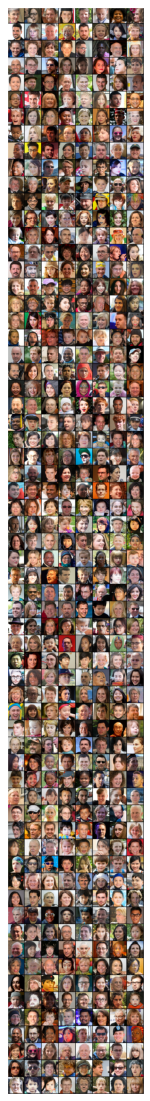

In [23]:
show_images(next(iter(loader)), 64)

# Часть 2. Построение и обучение модели (2 балла)

## Defining architectures

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [58]:
def weights_init(module):
    """
    The DCGAN paper (https://arxiv.org/abs/1511.06434v2) defines layer initialization as normal distribution with mean=0, stddev=0.02
    This function reinitializes all convolutional and batchnorm layers using these parameters.
    :param module: layer (of type nn.Module)
    """
    classname = module.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(module.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(module.weight.data, 1.0, 0.02)
        nn.init.constant_(module.bias.data, 0)

In [59]:
class GeneratorBlock(nn.Module):
    def __init__(self, input_channels, output_channels, dropout=False):
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.dropout = dropout
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(self.input_channels, self.output_channels, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.output_channels, momentum=0.8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )
        if self.dropout:
            self.layers.add_module(nn.Dropout2d(0.5))

    def forward(self, input):
        return self.layers(input)


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            GeneratorBlock(LATENT_SPACE_SIZE, 512, dropout=False),
            GeneratorBlock(512, 256, dropout=True),
            GeneratorBlock(256, 128, dropout=True),
            GeneratorBlock(128, 64, dropout=True),
            GeneratorBlock(64, 3, dropout=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.layers(input)

    def eval(self):
        self.train() # always stay in training mode (alters Dropout and BatchNorm behavior)

In [60]:
class DiscriminatorBlock(nn.Module):
    def __init__(self, input_channels, output_channels, noise=False, noise_sigma=None):
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.noise = noise
        self.noise_sigma = noise_sigma
        if self.noise and not noise_sigma:
            raise ValueError("Noise sigma not provided when noise usage is expected.")
        self.layer_defs = [
            nn.Conv2d(self.input_channels, self.output_channels, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.output_channels, momentum=0.8),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        []
        if self.noise:
            self.layer_defs.insert(0, GaussianNoise(sigma=self.noise_sigma))
        self.layers = nn.Sequential(*self.layer_defs)

    def forward(self, input):
        return self.layers(input)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            DiscriminatorBlock(3, 64),
            DiscriminatorBlock(64, 128, noise=True, noise_sigma=0.5),
            DiscriminatorBlock(128, 256, noise=True, noise_sigma=0.5),
            DiscriminatorBlock(256, 512, noise=True, noise_sigma=0.5),
            nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.layers(input)

In [61]:
generator = Generator().to(DEVICE)
generator.apply(weights_init)

Generator(
  (delinearizer): Sequential(
    (0): Linear(in_features=100, out_features=32768, bias=False)
    (1): Unflatten(dim=1, unflattened_size=(128, 16, 16))
  )
  (convs): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [62]:
torchinfo.summary(generator, (BATCH_SIZE, LATENT_SPACE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                --                        --
├─Sequential: 1-1                        [512, 128, 16, 16]        --
│    └─Linear: 2-1                       [512, 32768]              3,276,800
│    └─Unflatten: 2-2                    [512, 128, 16, 16]        --
├─Sequential: 1-2                        [512, 3, 64, 64]          --
│    └─BatchNorm2d: 2-3                  [512, 128, 16, 16]        256
│    └─Upsample: 2-4                     [512, 128, 32, 32]        --
│    └─Conv2d: 2-5                       [512, 128, 32, 32]        147,456
│    └─BatchNorm2d: 2-6                  [512, 128, 32, 32]        256
│    └─LeakyReLU: 2-7                    [512, 128, 32, 32]        --
│    └─Upsample: 2-8                     [512, 128, 64, 64]        --
│    └─Conv2d: 2-9                       [512, 64, 64, 64]         73,728
│    └─BatchNorm2d: 2-10                 [512, 64, 64, 64]         

In [63]:
discriminator = Discriminator().to(DEVICE)
discriminator.apply(weights_init)

Discriminator(
  (convs): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=1e-05, momentum=0.8, 

In [64]:
torchinfo.summary(discriminator, (BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [512, 2048]               --
│    └─Conv2d: 2-1                       [512, 16, 32, 32]         432
│    └─LeakyReLU: 2-2                    [512, 16, 32, 32]         --
│    └─Dropout2d: 2-3                    [512, 16, 32, 32]         --
│    └─Conv2d: 2-4                       [512, 32, 16, 16]         4,608
│    └─LeakyReLU: 2-5                    [512, 32, 16, 16]         --
│    └─Dropout2d: 2-6                    [512, 32, 16, 16]         --
│    └─BatchNorm2d: 2-7                  [512, 32, 16, 16]         64
│    └─Conv2d: 2-8                       [512, 64, 8, 8]           18,432
│    └─LeakyReLU: 2-9                    [512, 64, 8, 8]           --
│    └─Dropout2d: 2-10                   [512, 64, 8, 8]           --
│    └─BatchNorm2d: 2-11                 [512, 64, 8, 8]           128
│    └

In [65]:
!nvidia-smi

Mon Jan 10 19:15:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0   112W / 149W |   3970MiB / 11441MiB |     53%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Training DCGAN

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [66]:
models = {
    "discriminator": discriminator,
    "generator": generator
}

criteria = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

optimizers = {
    "discriminator": torch.optim.AdamW(discriminator.parameters(), lr=1e-3, betas=(0.5, 0.999)),
    "generator": torch.optim.AdamW(generator.parameters(), lr=3e-4, betas=(0.5, 0.999))
}


Epoch  100, generator loss:  0.4009,     discriminator loss  0.1253, real score:  0.6643,     fake score:  0.4040


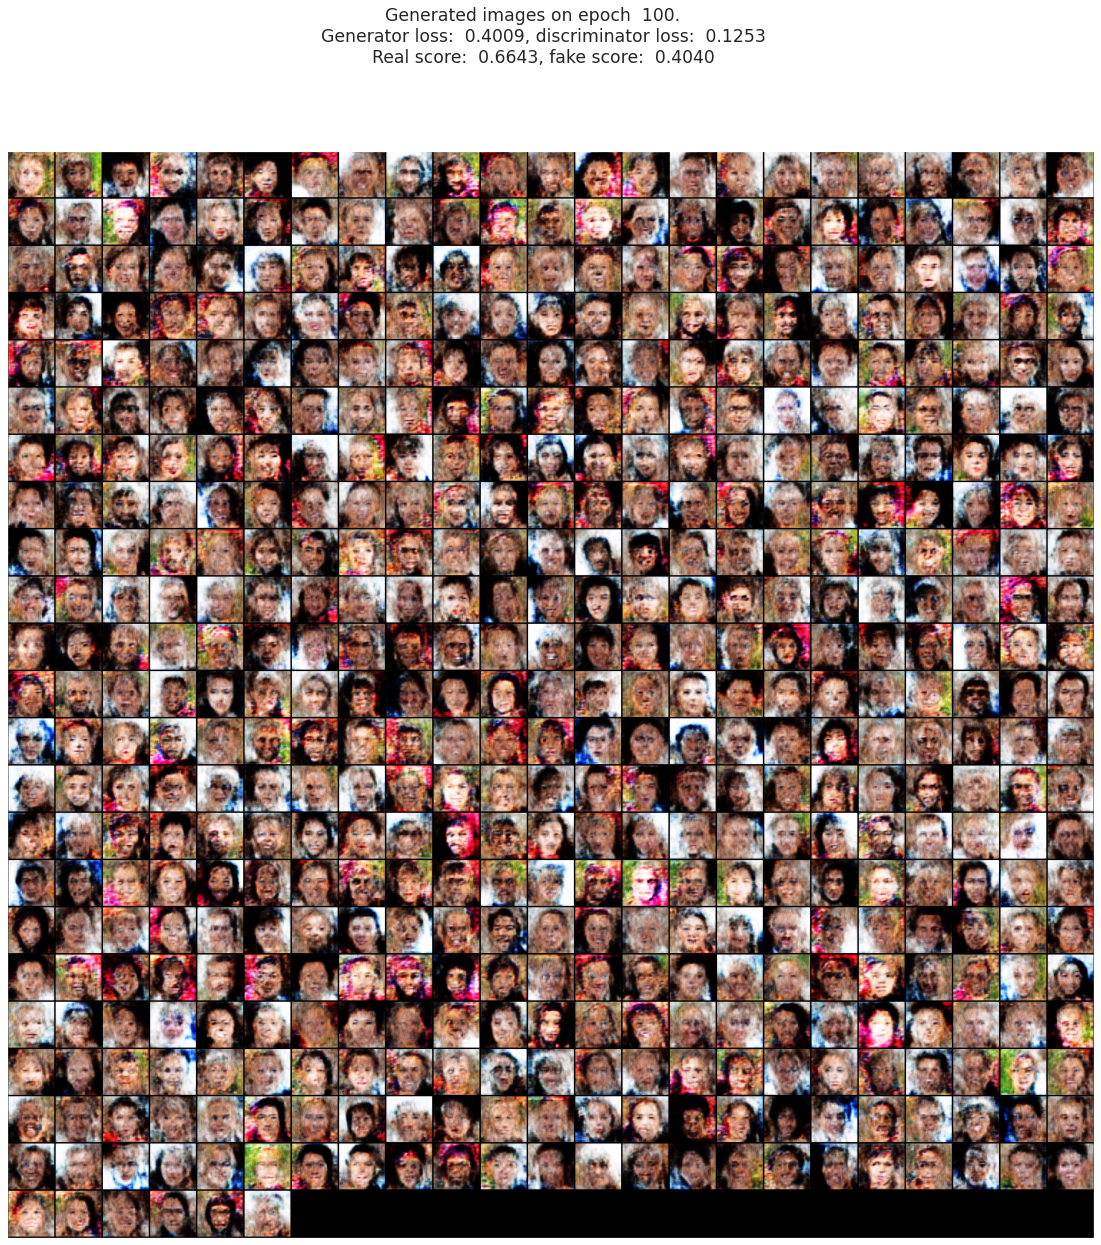

Saving generated images to generated-images-100.png
Overall training time:  3246.3 seconds


In [67]:
max_epochs = 100
history_gan = train_model(loader, models, optimizers, criteria, max_epochs, BATCH_SIZE, LATENT_SPACE_SIZE)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

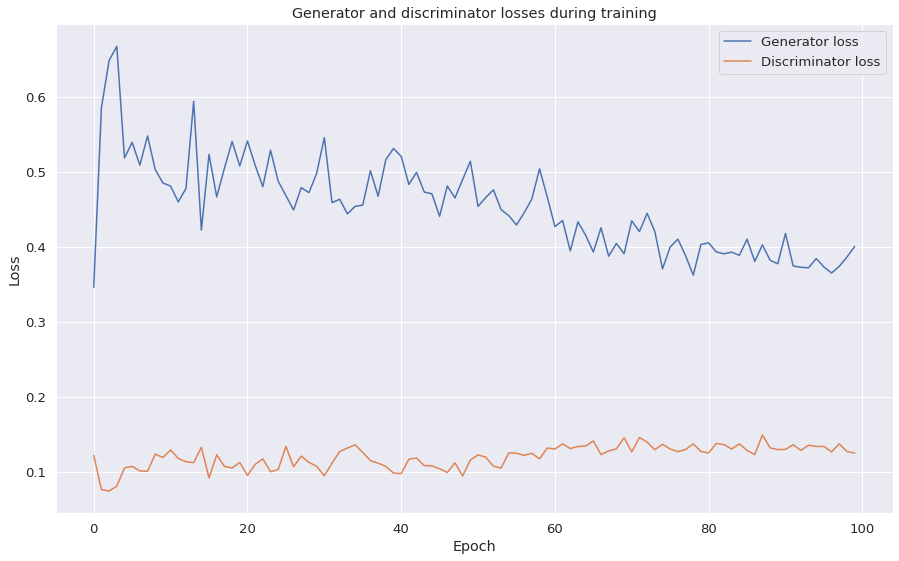

In [68]:
plot_losses(history_gan)

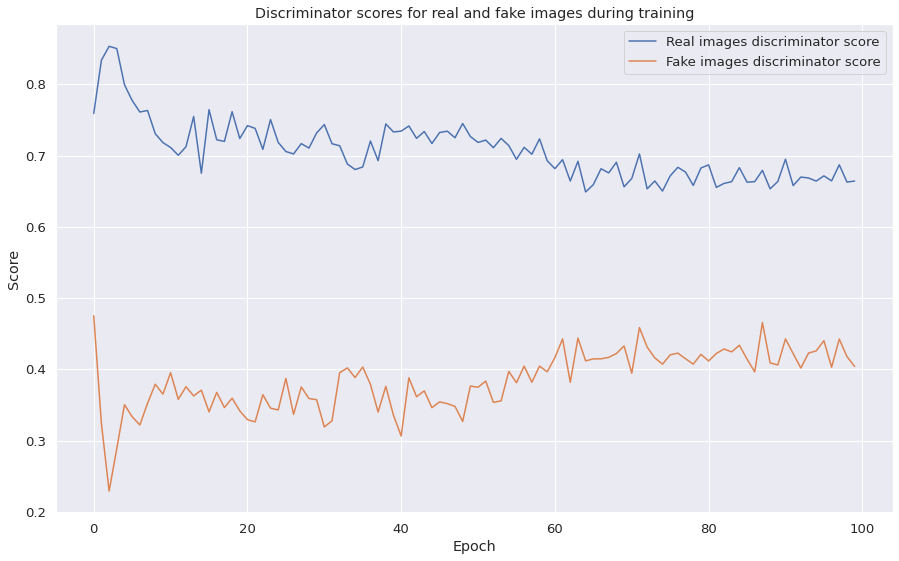

In [69]:
plot_scores(history_gan)

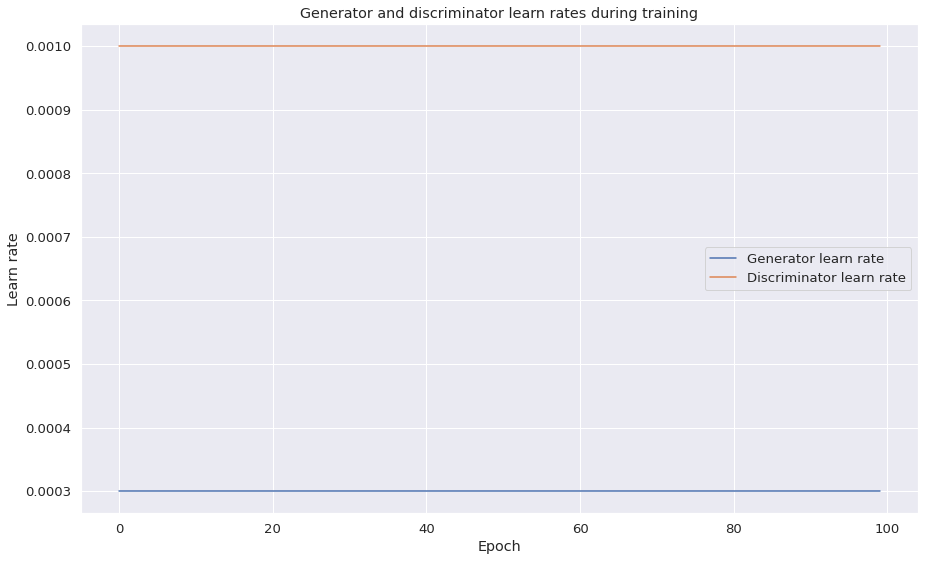

In [70]:
plot_learn_rates(history_gan)

# Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

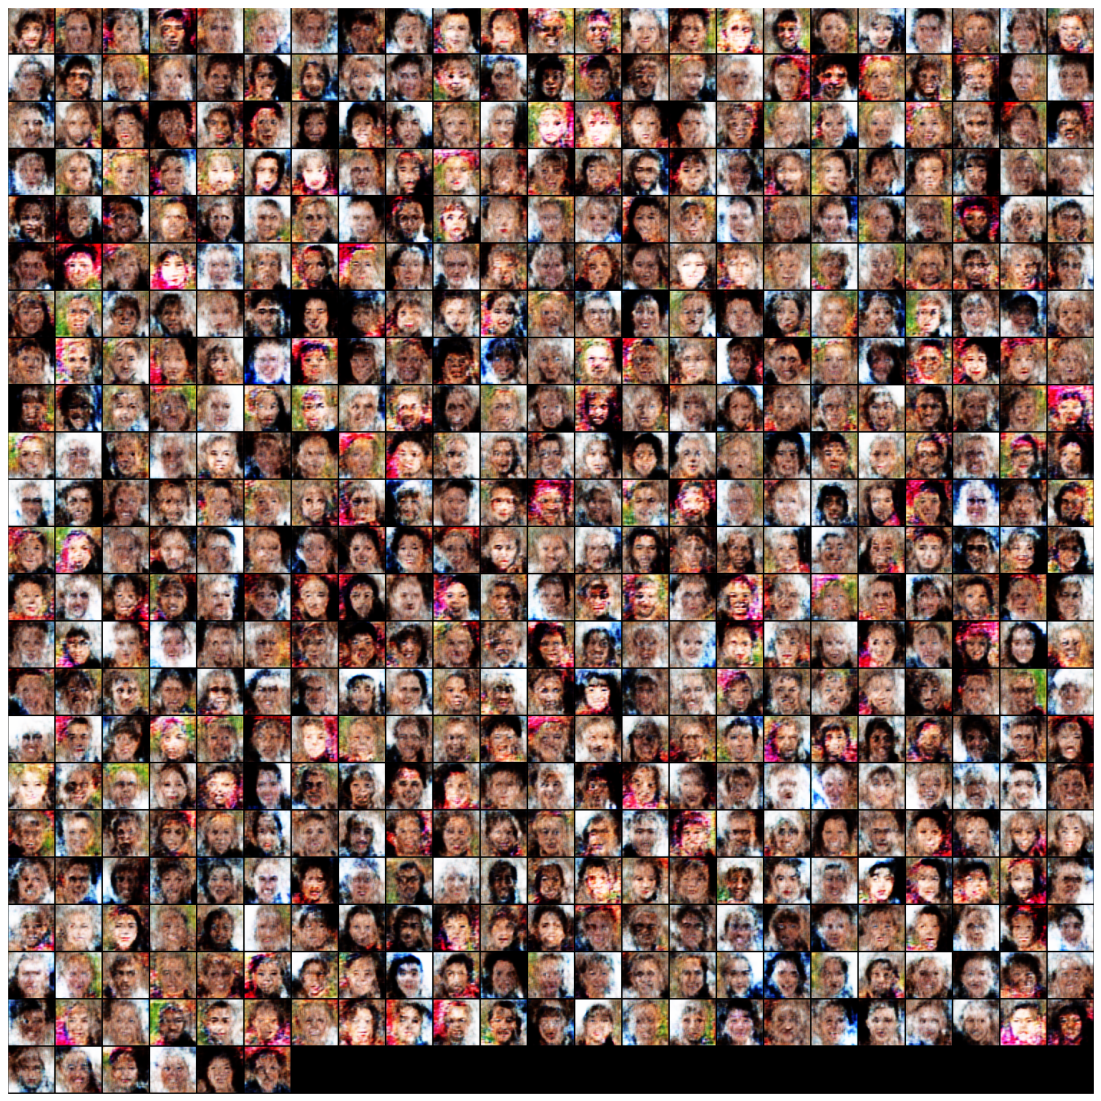

In [75]:
fixed_latent = torch.normal(0, 1, size=(BATCH_SIZE, LATENT_SPACE_SIZE, 1, 1), device=DEVICE)
with torch.no_grad():
    fake_images = models["generator"](fixed_latent).detach().cpu()
fixed_latent = fixed_latent.cpu()
del fixed_latent
torch.cuda.empty_cache()
show_images(fake_images, BATCH_SIZE)

Как вам качество получившихся изображений?

Похоже на лица, но довольно мутно + присутствуют шумы.

Возможные методы исправления:
* Изменение гиперпараметров оптимизаторов или самих оптимизаторов, например, использовать SGD для дискриминатора и Adam для генератора, или Adam для обеих сетей. Также можно настраивать lr и $\beta_1$/$\beta_2$ (в случае Adam).
* Изменение лосса с MSE на бинарную кросс-энтропию и обратно.
* Изменение количества эпох (возможно, модель недообучена).
* Сохранение чекпоинтов генератора и дискриминатора на некоторых эпохах и периодическая замена весов на веса из чекпоинтов (чтобы та сеть, которая не смогла дообучиться, дообучилась бы).
* Добавление шума в генератор (поэкспериментировать с количеством слоёв, входы на которые зашумляются).
* Дропауты в генераторе.
* [Wasserstein GANs](https://arxiv.org/abs/1701.07875) или их модификация (например, [Improved Training of Wasserstein GANs](https://arxiv.org/pdf/1704.00028.pdf)).
* [Energy-based GANs](https://arxiv.org/abs/1609.03126).

# Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [105]:
def generate_fakes(loader, generator, batch_size, latent_size):
    generator.eval()
    fakes = []
    for real in tqdm.tqdm(loader, desc="Generating fakes"):
        try:
            latent = torch.normal(0, 1, size=(BATCH_SIZE, LATENT_SPACE_SIZE, 1, 1), device=DEVICE)
            with torch.no_grad():
                outputs = generator(latent).detach().cpu()
            fakes.append(outputs)
        finally:
            latent = latent.cpu()
            del latent
            torch.cuda.empty_cache()
    return torch.flatten(torch.stack(fakes), end_dim=1)

In [106]:
real = torch.flatten(torch.stack([i for i in tqdm.tqdm(loader, desc="Loading real images")]), end_dim=1)
fakes = generate_fakes(loader, models["generator"], BATCH_SIZE, LATENT_SPACE_SIZE)

Loading real images:   0%|          | 0/6 [00:00<?, ?it/s]

Generating fakes:   0%|          | 0/6 [00:00<?, ?it/s]

In [107]:
X = torch.flatten(torch.stack([real, fakes]), end_dim=1).numpy()
y = torch.flatten(torch.stack([torch.Tensor([1 for i in real]), torch.Tensor([0 for i in fakes])]), end_dim=1).numpy()

In [108]:
def fit_1nn_per_image(X, y, train_idx, test_idx):
    one_nn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    X_train, X_test = X_train.reshape(X_train.shape[0], -1), X_test.reshape(X_test.shape[0], -1)
    one_nn.fit(X_train, y_train)
    y_pred = one_nn.predict(X_test)
    return sklearn.metrics.accuracy_score(y_test, y_pred)

In [110]:
loo = sklearn.model_selection.LeaveOneOut()

accuracies = joblib.Parallel(n_jobs=-1)(joblib.delayed(fit_1nn_per_image)(X, y, train_idx, test_idx) for i in tqdm.tqdm(loo.split(X), total=loo.get_n_splits(X), desc="Making 1NN LOO accuracies"))

print(f"Mean 1NN accuracy: {np.mean(accuracies)}")

Making 1NN LOO accuracies:   0%|          | 0/6144 [00:00<?, ?it/s]

Mean 1NN accuracy: 1.0


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [113]:
print(X)

[[[[-7.56862760e-01 -8.50980401e-01 -9.05882359e-01 ...  1.17647648e-02
    -2.74509192e-02  3.92162800e-03]
   [-5.84313691e-01 -8.90196085e-01 -8.82352948e-01 ... -1.76470518e-01
    -9.01960135e-02 -5.88234663e-02]
   [-6.70588255e-01 -8.98039222e-01 -8.98039222e-01 ... -2.94117630e-01
    -2.23529339e-01 -1.37254834e-01]
   ...
   [-1.76470518e-01  7.45098591e-02  3.09803963e-01 ... -9.21568632e-01
    -9.13725495e-01 -9.05882359e-01]
   [-2.15686202e-01 -5.88234663e-02 -6.66666031e-02 ... -9.21568632e-01
    -9.13725495e-01 -9.13725495e-01]
   [-3.01960766e-01 -2.54901946e-01 -2.62745082e-01 ... -9.21568632e-01
    -9.21568632e-01 -9.05882359e-01]]

  [[-7.41176486e-01 -8.35294127e-01 -8.90196085e-01 ... -3.80392134e-01
    -3.88235271e-01 -3.64705861e-01]
   [-5.60784280e-01 -8.66666675e-01 -8.66666675e-01 ... -4.82352912e-01
    -4.03921545e-01 -3.88235271e-01]
   [-6.39215708e-01 -8.74509811e-01 -8.82352948e-01 ... -5.45098007e-01
    -4.90196049e-01 -4.19607818e-01]
   ...
   

In [112]:
images_compressed = sklearn.manifold.TSNE(n_components=2, verbose=1).fit_transform(X)
print("[t-SNE] Done.")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


ValueError: ignored

In [ ]:
def plot_latent_compressed(data, targets, num_classes=2):
    plt.figure(figsize=(20, 10))
    d = {i:[] for i in range(num_classes)}
    
    for j in range(num_classes):
        if j in targets:
            mask = (targets == j)
            d[j].append(data[mask])

    colors = list(matplotlib.colors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(d[i][:, 0], d[i][:, 1], c=colors[i][1], label=f"{"real" if i else "fake"}", alpha=0.5)
        
    kmeans = sklearn.cluster.KMeans(n_clusters=num_classes)
    X = np.concatenate(list(d.values()))
    labels = kmeans.fit_predict(X)
    centroids = kmeans.cluster_centers_
    for i, center in enumerate(centroids):
        plt.text(center[0], center[1], str(i), fontdict={"size": 20, "weight": "bold"})
        
    plt.title("Real/fake pictures distribution")
    plt.colorbar()
    plt.legend()
    plt.plot();

In [ ]:
plot_latent_compressed(X, y)

Прокомментируйте получившийся результат: